In [ ]:
#!cp /content/drive/MyDrive/coen344-cv1-project/model-sp.py /content

In [1]:
from glob import glob
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import time
import os
import numpy as np

import random
import cv2
from google.colab import drive
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
drive.mount('/content/drive')

Instructions for updating:
non-resource variables are not supported in the long term


Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import csv

In [3]:
epoch = 10
batch_size = 128
lr = 0.001
use_gpu = 1
# phase = 'test' # train or test
store_true = False # use temporal model
ckpt_dir = '/content/drive/MyDrive/coen344-cv1-project/checkpoint-mixed' #save models here
test_dir = '/content/drive/MyDrive/coen344-cv1-project/output-mixed/' #save denoised samples here

# import argparse
# parser = argparse.ArgumentParser(description='')
# parser.add_argument('--epoch', dest='epoch', type=int, default=10, help='# of epochs')
# parser.add_argument('--batch_size', dest='batch_size', type=int, default=128, help='# images in batch')
# parser.add_argument('--lr', dest='lr', type=float, default=0.001, help='initial learning rate for adam')
# parser.add_argument('--use_gpu', dest='use_gpu', type=int, default=1, help='gpu flag, 1 for GPU and 0 for CPU')
# parser.add_argument('--phase', dest='phase', default='test', help='train or test')
# parser.add_argument('--temporal', action='store_true', default=False, help='Use temporal model')
# parser.add_argument('--checkpoint_dir', dest='ckpt_dir', default='/content/drive/MyDrive/coen344-cv1-project/checkpoint', help='models are saved here')
# parser.add_argument('--test_dir', dest='test_dir', default='/content/drive/MyDrive/coen344-cv1-project/output-sp', help='denoised sample are saved here')
# args, _ = parser.parse_known_args()

In [4]:
# model.py

def dncnn(input, is_training=True, output_channels=3):
    with tf.compat.v1.variable_scope('block1'):
        output = tf.compat.v1.layers.conv2d(input, 64, 3, padding='same', activation=tf.nn.relu)
    for layers in range(2, 15+1): #<--adjust layers here
        with tf.compat.v1.compat.v1.variable_scope('block%d' % layers):
            output = tf.compat.v1.layers.conv2d(output, 64, 3, padding='same', name='conv%d' % layers, use_bias=False)
            output = tf.compat.v1.nn.relu(tf.compat.v1.layers.batch_normalization(output, training=is_training))   
    with tf.compat.v1.variable_scope('block17'):
        output = tf.compat.v1.layers.conv2d(output, output_channels, 3, padding='same',use_bias=False)
    return input - output

# # training filepaths
filepaths1 = glob('/content/drive/MyDrive/coen344-cv1-project/data/Gaussian-train/original/*.png') 
# filepaths = sorted(filepaths)   
filepaths2 = glob('/content/drive/MyDrive/coen344-cv1-project/data/SP-train/original-sp/*.png')   

filepaths_noisy1 = glob('/content/drive/MyDrive/coen344-cv1-project/data/Gaussian-train/noisy/*.png')
# filepaths_noisy = sorted(filepaths_noisy)
filepaths_noisy2 = glob('/content/drive/MyDrive/coen344-cv1-project/data/SP-train/noisy-sp/*.png')

filepaths=[]
filepaths_noisy=[]
for start_i in range(len(filepaths1)):
  end_i = len(filepaths1)-1-start_i
  filepaths.append(filepaths1[start_i])
  filepaths.append(filepaths2[end_i])
  filepaths_noisy.append(filepaths_noisy1[start_i])
  filepaths_noisy.append(filepaths_noisy1[end_i])

ind = range(len(filepaths))


# filepaths = glob('/content/drive/MyDrive/coen344-cv1-project/data/Gaussian-train/original/*.png') 
# filepaths = sorted(filepaths)  
# filepaths_noisy = glob('/content/drive/MyDrive/coen344-cv1-project/data/Gaussian-train/noisy/*.png')
# filepaths_noisy = sorted(filepaths_noisy)
# ind = range(len(filepaths))

# Commented out IPython magic to ensure Python compatibility.
class denoiser(object):
    def __init__(self, sess, input_c_dim=3, batch_size=128):
        self.sess = sess
        self.input_c_dim = input_c_dim
        # build model
        self.Y_ = tf1.placeholder(tf.float32, [None, None, None, self.input_c_dim],
                                 name='clean_image')
        self.is_training = tf1.placeholder(tf.bool, name='is_training')
        self.X = tf1.placeholder(tf1.float32, [None, None, None, self.input_c_dim])
        self.Y = dncnn(self.X, is_training=self.is_training)
        self.loss = (1.0 / batch_size) * tf.nn.l2_loss(self.Y_ - self.Y)
        self.lr = tf.Variable(0.001, dtype=tf.float32, name='learning_rate')
        #self.lr = tf1.Tensor(0,tf1.float32, name='learning_rate')
        self.dataset = dataset(sess)
        # optimizer = tf.keras.optimizers.Adam(self.lr)
        optimizer = tf1.train.AdamOptimizer(self.lr)
        update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
        with tf.compat.v1.control_dependencies(update_ops):
            self.train_op = optimizer.minimize(self.loss)
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
        print("[*] Initialize model successfully...")

    def evaluate(self, iter_num, eval_files, noisy_files, summary_writer):
        print("[*] Evaluating...")
        psnr_sum = 0
        mse_sum = 0
        snr_sum = 0
        
        for i in range(10):
            clean_image = cv2.imread(eval_files[i])
            clean_image = clean_image.astype('float32') / 255.0
            clean_image = clean_image[np.newaxis, ...]
            #clean_image = clean_image[None, :, :, :]
            noisy = cv2.imread(noisy_files[i])
            noisy = noisy.astype('float32') / 255.0
            noisy = noisy[np.newaxis, ...]
            
            output_clean_image = self.sess.run(
                [self.Y],feed_dict={self.Y_: clean_image,
                           self.X: noisy,
                           self.is_training: False})
            psnr,mse,snr = psnr_scaled(clean_image, output_clean_image)
            print("img%d PSNR: %.2f" % (i + 1, psnr))
            psnr_sum += psnr
            mse_sum += mse
            snr_sum += snr

        avg_psnr = psnr_sum / 10
        avg_mse = mse_sum / 10
        avg_snr = snr_sum / 10

        print("Validate: --- Average PSNR %.2f --- Average MSE %.2f --- Average SNR %.2f" % (avg_psnr, avg_mse, avg_snr)) 

    def train(self, eval_files, noisy_files, batch_size, ckpt_dir, epoch, lr, eval_every_epoch=1):

        numBatch = int(len(filepaths) * 2)
        #numBatch = int(len(filepaths))
        # load pretrained model
        load_model_status, global_step = self.load(ckpt_dir)
        if load_model_status:
            iter_num = global_step
            start_epoch = global_step // numBatch
            start_step = global_step % numBatch
            print("[*] Model restore success!")
        else:
            iter_num = 0
            start_epoch = 0
            start_step = 0
            print("[*] Not find pretrained model!")
        # make summary
        tf1.summary.scalar('loss', self.loss)
        tf1.summary.scalar('lr', self.lr)
        print('collections', tf1.get_collection(tf1.GraphKeys.SUMMARIES))
        #writer = tf1.summary.FileWriter('./logs', self.sess.graph)
        #merged = tf1.summary.merge_all()
        writer = tf.compat.v1.summary.FileWriter('./logs', self.sess.graph)
        merged = tf.compat.v1.summary.merge_all()
        print('xx',merged)
        clip_all_weights = tf1.get_collection("max_norm")        

        print("[*] Start training, with start epoch %d start iter %d : " % (start_epoch, iter_num))
        start_time = time.time()
        self.evaluate(iter_num, eval_files, noisy_files, summary_writer=writer)  # eval_data value range is 0-255
        loss_values = []
        for epoch in range(start_epoch, epoch):
            batch_noisy = np.zeros((batch_size,64,64,3),dtype='float32')
            batch_images = np.zeros((batch_size,64,64,3),dtype='float32')
            for batch_id in range(start_step, numBatch):
              try:
                res = self.dataset.get_batch() # If we get an error retrieving a batch of patches we have to reinitialize the dataset
              except KeyboardInterrupt:
                raise
              except:
                self.dataset = dataset(self.sess) # Dataset re init
                res = self.dataset.get_batch()
              if batch_id==0:
                batch_noisy = np.zeros((batch_size,64,64,3),dtype='float32')
                batch_images = np.zeros((batch_size,64,64,3),dtype='float32')
              ind1 = range(int(res.shape[0]/2))
              ind1 = np.multiply(ind1,2)
              for i in range(batch_size):
                random.shuffle(ind1)
                ind2 = random.randint(0,8-1)
                batch_noisy[i] = res[ind1[0],ind2]
                batch_images[i] = res[ind1[0]+1,ind2]
                #print('x', [self.train_op, self.loss, merged])
              _, loss, summary = self.sess.run(fetches = [self.train_op, self.loss, merged],
                                                 feed_dict={self.Y_: batch_images, self.X: batch_noisy, self.lr: lr[epoch],
                                                            self.is_training: True})
              self.sess.run(clip_all_weights)          
              
              print("Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f"
                     % (epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
              iter_num += 1
              writer.add_summary(summary, iter_num)
              loss_values.append(loss)
              
            if np.mod(epoch + 1, eval_every_epoch) == 0: ##Evaluate and save model
                self.evaluate(iter_num, eval_files, noisy_files, summary_writer=writer)
                self.save(iter_num, ckpt_dir)
        print("[*] Training finished.")

        import matplotlib.pyplot as plt
        plt.plot(loss_values)
        plt.title("Training Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()

    def save(self, iter_num, ckpt_dir, model_name='DnCNN-tensorflow'):
        saver = tf1.train.Saver()
        checkpoint_dir = ckpt_dir
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        print("[*] Saving model...")
        saver.save(self.sess,
                   os.path.join(checkpoint_dir, model_name),
                   global_step=iter_num)

    def load(self, checkpoint_dir):
        print("[*] Reading checkpoint...")
        saver = tf1.train.Saver()
        ckpt = tf1.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            full_path = tf1.train.latest_checkpoint(checkpoint_dir)
            global_step = int(full_path.split('/')[-1].split('-')[-1])
            saver.restore(self.sess, full_path)
            return True, global_step
        else:
            return False, 0

    def test(self, eval_files, noisy_files, ckpt_dir, save_dir, temporal):
        """Test DnCNN"""
        # init variables
        tf1.global_variables_initializer().run()
        assert len(eval_files) != 0, 'No testing data!'
        load_model_status, global_step = self.load(ckpt_dir)
        assert load_model_status == True, '[!] Load weights FAILED...'
        print(" [*] Load weights SUCCESS...")

        psnr_sum = 0
        mse_sum = 0
        snr_sum = 0
            
        for i in range(len(eval_files)):
            clean_image = cv2.imread(eval_files[i])
            clean_image = clean_image.astype('float32') / 255.0
            clean_image = clean_image[np.newaxis, ...]
            
            noisy = cv2.imread(noisy_files[i])
            noisy = noisy.astype('float32') / 255.0
            noisy = noisy[np.newaxis, ...] 
          
            output_clean_image = self.sess.run(
                [self.Y],feed_dict={self.Y_: clean_image, self.X: noisy,
                                    self.is_training: False})
            
            out1 = np.asarray(output_clean_image)
               
            psnr,mse,snr = psnr_scaled(clean_image, out1[0,0]) #clean to denoised
            psnr1,mse1,snr1 = psnr_scaled(clean_image, noisy) #clean to noisy
            
            print("img%d PSNR: %.2f , noisy PSNR: %.2f, MSE: %.2f , noisy MSE: %.2f, SNR: %.2f , noisy SNR: %.2f" % 
                  (i + 1, psnr, psnr1, mse, mse1, snr, snr1))
            psnr_sum += psnr
            mse_sum += mse
            snr_sum += snr

            cv2.imwrite(save_dir+'denoised-gaussian/%04d.png'%(i),out1[0,0]*255.0)

            csv.csvwriter.writerows([[psnr, psnr1, mse, mse1, snr, snr1]])

        avg_psnr = psnr_sum / len(eval_files)
        avg_mse = mse_sum / len(eval_files)
        avg_snr = snr_sum / len(eval_files)
        print("--- Test ---- Average PSNR %.2f --- Average MSE %.2f --- Average SNR %.2f" % (avg_psnr,avg_mse,avg_snr))
        csv.csvwriter.writerows([[avg_psnr, 0, avg_mse, 0, avg_snr, 0]])

    
class dataset(object):
  def __init__(self,sess):
    self.sess = sess
    seed = time.time()
    random.seed(seed)
    idxs = list(ind)
    random.shuffle(idxs)
    
    filenames = list()
    for i in range(len(filepaths)):
        filenames.append(filepaths_noisy[idxs[i]])
        filenames.append(filepaths[idxs[i]])

    # Parameters
    num_patches = 8   # number of patches to extract from each image
    patch_size = 64                 # size of the patches
    num_parallel_calls = 1          # number of threads
    batch_size = 32                # size of the batch
    get_patches_fn = lambda image: get_patches(image, num_patches=num_patches, patch_size=patch_size)
    dataset = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(im_read, num_parallel_calls=num_parallel_calls)
        .map(get_patches_fn, num_parallel_calls=num_parallel_calls)
        .batch(batch_size)
        .prefetch(batch_size)
    )
    
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    self.iter = iterator.get_next()
  

  def get_batch(self):
        res = self.sess.run(self.iter)
        return res
        
def im_read(filename):
    """Decode the png image from the filename and convert to [0, 1]."""
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=3)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    return image
    
def get_patches(image, num_patches=128, patch_size=64):
    """Get `num_patches` from the image"""
    patches = []
    for i in range(num_patches):
      point1 = random.randint(0,116) # 116 comes from the image source size (180) - the patch dimension (64)
      point2 = random.randint(0,116)
      patch = tf.image.crop_to_bounding_box(image, point1, point2, patch_size, patch_size)
      patches.append(patch)
    patches = tf.stack(patches)
    assert patches.get_shape().dims == [num_patches, patch_size, patch_size, 3]
    return patches
    
# def cal_psnr(im1, im2): # PSNR function for 0-255 values
#     mse = ((im1.astype(np.float) - im2.astype(np.float)) ** 2).mean()
#     psnr = 10 * np.log10(255 ** 2 / mse)
#     return psnr
    
def psnr_scaled(im1, im2): # PSNR function for 0-1 values
    im2 = np.asarray(im2)
    mse = ((im1 - im2) ** 2).mean()
    mse = mse * (255 ** 2)
    psnr = 10 * np.log10(255 **2 / mse)
    snr = (im1.mean()**2)/(im2.mean()**2) #original to noisy
    return psnr, mse, snr

In [5]:
def denoiser_train(denoiser, lr):
  # noisy_eval_files = glob('/content/drive/MyDrive/coen344-cv1-project/data/Gaussian-train/noisy/*.png')
  # noisy_eval_files = sorted(noisy_eval_files)
  # eval_files = glob('/content/drive/MyDrive/coen344-cv1-project/data/Gaussian-train/original/*.png')
  # eval_files = sorted(eval_files)
  noisy_eval_files = filepaths_noisy
  eval_files = filepaths
  denoiser.train(eval_files, noisy_eval_files, batch_size=batch_size, ckpt_dir=ckpt_dir, epoch=epoch, lr=lr)

def denoiser_test(denoiser):

  noisy_eval_files = glob('/content/drive/MyDrive/coen344-cv1-project/data/Gaussian-test/noisy/*.png')
  noisy_eval_files = sorted(noisy_eval_files)
  eval_files = glob('/content/drive/MyDrive/coen344-cv1-project/data/Gaussian-test/original/*.png')
  eval_files = sorted(eval_files)
  start = time.time()
  denoiser.test(eval_files, noisy_eval_files, ckpt_dir=ckpt_dir, 
                save_dir=test_dir, #folder to save denoised images
                temporal=store_true)
  end = time.time()
  print ("Elapsed time:", end-start)

In [6]:
epoch = 10
batch_size = 128
# lr = 0.001
use_gpu = 1
# phase = 'test' # train or test
store_true = False # use temporal model

def main():
    tf.compat.v1.reset_default_graph()
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    lr = 0.001
    lr = lr * np.ones([epoch])
    lr[30:] = lr[0] / 10.0
    if use_gpu:
        # added to control the gpu memory
        print("GPU\n")
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
        with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            model = denoiser(sess) #<--instantiate model
            if phase == 'train':
                denoiser_train(model, lr=lr)
            elif phase == 'test':
                denoiser_test(model)
            else:
                print('[!]Unknown phase')
                exit(0)
    else:
        print("CPU\n")
        with tf.compat.v1.Session() as sess:
            model = denoiser(sess) #<--instantiate model
            if  phase == 'train':
                denoiser_train(model, lr=lr)
            elif  phase == 'test':
                denoiser_test(model)
            else:
                print('[!]Unknown phase')
                exit(0)

def test():
 #   gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
    
    gpu_options = tf.compat.v1.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
    with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
      model = denoiser(sess) #<--instantiate model
      denoiser_test(model)

  
# if __name__ == '__main__':
#     tf.compat.v1.app.run()

GPU



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Streaming output truncated to the last 5000 lines.
Epoch: [ 7] [1454/1600] time: 2410.8357, loss: 347.441589
Epoch: [ 7] [1455/1600] time: 2410.9281, loss: 372.053375
Epoch: [ 7] [1456/1600] time: 2411.0204, loss: 309.482849
Epoch: [ 7] [1457/1600] time: 2411.1131, loss: 348.940552
Epoch: [ 7] [1458/1600] time: 2411.2061, loss: 367.244843
Epoch: [ 7] [1459/1600] time: 2411.2998, loss: 345.706818
Epoch: [ 7] [1460/1600] time: 2411.3920, loss: 386.430359
Epoch: [ 7] [1461/1600] time: 2411.4850, loss: 321.649231
Epoch: [ 7] [1462/1600] time: 2411.5774, loss: 325.911377
Epoch: [ 7] [1463/1600] time: 2411.6692, loss: 405.007324
Epoch: [ 7] [1464/1600] time: 2411.7612, loss: 413.165985
Epoch: [ 7] [1465/1600] time: 2411.8546, loss: 393.814056
Epoch: [ 7] [1466/1600] time: 2411.9471, loss: 356.809662
Epoch: [ 7] [1467/1600] time: 2412.0394, loss: 339.312103
Epoch: [ 7] [1468/1600] time: 2412.1314, loss: 428.599274
Epoch: [ 7] [1469/1600] time: 2412.2231, loss: 367.068573
Epoch: [ 7] [1470/160

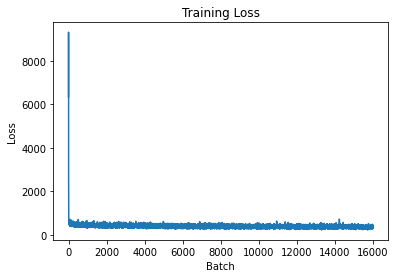

In [7]:
# TRAIN GAUSSIAN 
phase = 'train'
main()

In [8]:
 # TEST SP

csvfile = open(test_dir+'train-mixed-test-gaussian.csv', 'w')
csv.csvwriter = csv.writer(csvfile) 
csv.csvwriter.writerow(["psnr","noisy psnr","mse","noisy mse","snr","noisy snr"]) 

phase = 'test'
main()

csvfile.close()

GPU

[*] Initialize model successfully...
[*] Reading checkpoint...
 [*] Load weights SUCCESS...
img1 PSNR: 12.68 , noisy PSNR: 20.25, MSE: 3510.93 , noisy MSE: 614.25, SNR: 0.51 , noisy SNR: 1.01
img2 PSNR: 12.28 , noisy PSNR: 20.19, MSE: 3844.39 , noisy MSE: 621.78, SNR: 0.57 , noisy SNR: 1.01
img3 PSNR: 11.64 , noisy PSNR: 20.30, MSE: 4454.26 , noisy MSE: 606.96, SNR: 0.48 , noisy SNR: 1.00
img4 PSNR: 10.82 , noisy PSNR: 20.84, MSE: 5386.79 , noisy MSE: 536.01, SNR: 0.29 , noisy SNR: 0.96
img5 PSNR: 10.74 , noisy PSNR: 20.41, MSE: 5488.20 , noisy MSE: 592.15, SNR: 0.63 , noisy SNR: 1.01
img6 PSNR: 10.79 , noisy PSNR: 20.43, MSE: 5421.33 , noisy MSE: 588.70, SNR: 0.38 , noisy SNR: 1.00
img7 PSNR: 10.42 , noisy PSNR: 20.39, MSE: 5899.55 , noisy MSE: 594.65, SNR: 0.79 , noisy SNR: 1.02
img8 PSNR: 8.31 , noisy PSNR: 20.78, MSE: 9587.59 , noisy MSE: 543.10, SNR: 1.12 , noisy SNR: 1.02
img9 PSNR: 11.56 , noisy PSNR: 20.43, MSE: 4545.24 , noisy MSE: 589.34, SNR: 1.02 , noisy SNR: 1.01
img1

In [ ]:
# ckpt = tf1.train.get_checkpoint_state('/content/drive/MyDrive/coen344-cv1-project/checkpoint-yifan')
# type(ckpt)

tensorflow.python.training.checkpoint_state_pb2.CheckpointState

In [ ]:
# ckpt.model_checkpoint_path = '/content/drive/MyDrive/coen344-cv1-project/checkpoint-yifan/DnCNN-tensorflow-4000'

In [ ]:
# im1 = cv2.imread('/content/drive/MyDrive/coen344-cv1-project/data/SP-test/original/0036.png')
# im2 = cv2.imread('/content/drive/MyDrive/coen344-cv1-project/data/SP-test/noisy/0036.png')
# # (im1.mean()**2)/(im2.mean()**2)

[9, 5, 1, 8, 2, 0, 3, 6, 4, 7]